# Лабораторная работа №1. 

Данная лабораторная работа состоит из нескольких блоков. В каждом блоке вам предлагается произвести некоторые манипуляции с данными и сделать некоторые выводы.
* Задавать вопросы можно и нужно.
* Списывать не нужно. Работы, которые были списаны обнуляются.
* Блоки выполняются последовательно и оцениваются отдельно.

## Часть 1. Работа с моделями и ансамблями моделей в задачи классификации.

### 1. Чтение данных.
Воспользуемся [датасетом](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), в котором описываются различные автомобили. Будем решать задачу многоклассовой ($k=4$) классификации.
Для удобства, датасет уже преобразован в удобный формат.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

print(data.shape, target.shape)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(846, 19) (846,)
(549, 19) (549,) (297, 19) (297,)


In [2]:
def my_train_test_split():
    dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
    data = dataset[:, :-1].astype(int)
    target = dataset[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35)
    
    # нормализуем данные, чтобы алгоритм быстрее сходился и для PCA
    tr = StandardScaler()
    X_train = tr.fit_transform(X_train)
    X_test = tr.transform(X_test)

    # приводи таргет к числам, чтобы обучить лог. регр.
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train.reshape(-1,))
    y_test = encoder.transform(y_test.reshape(-1,))

    return X_train, X_test, y_train, y_test

Для первичного анализа может быть полезна библиотека `pandas`. Преобразуем `train` выборку в `pd.DataFrame`.

In [51]:
X_train_pd = pd.DataFrame(X_train)

# First 15 rows of our dataset.
X_train_pd.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,701,108,49,103,200,62,10,206,32,23,155,227,635,215,72,6,16,189,198
1,749,93,51,90,209,69,8,183,36,22,156,211,506,230,70,6,1,189,196
2,378,82,36,54,117,53,7,125,54,18,126,146,229,128,78,1,5,180,184
3,475,97,55,104,219,71,9,211,32,24,171,222,658,223,74,1,24,186,196
4,545,88,44,84,135,55,12,155,44,20,158,176,351,164,75,7,11,183,195
5,46,91,43,70,133,55,8,130,51,18,146,159,253,156,70,1,8,190,194
6,604,88,40,79,183,62,7,176,38,21,138,200,462,150,66,0,29,189,199
7,497,94,43,82,136,54,10,155,43,19,149,176,359,161,74,1,6,186,197
8,826,95,49,92,193,62,10,178,37,21,154,200,478,171,64,2,0,198,206
9,663,89,47,83,169,61,8,164,40,20,150,189,402,190,72,7,10,187,193


In [28]:
print(f"{len(np.unique(y_train))} классовая классификация")

4 классовая классификация


Воспользовавшись методами `describe` и `info` можно получить полезную информацию о датасете.

In [3]:
X_train_pd.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,425.963570,93.353370,44.728597,81.573770,167.630237,61.621129,8.544627,167.941712,41.114754,20.510018,147.595628,187.837887,434.989071,174.051002,72.695811,6.249545,12.255009,188.803279,195.369763
std,247.749849,8.233748,6.043420,15.587653,32.808334,7.596724,4.709859,32.719448,7.700338,2.550653,14.269706,30.719611,174.168294,31.945111,7.462583,4.936977,8.934096,6.242478,7.482576
min,0.000000,73.000000,33.000000,42.000000,104.000000,47.000000,3.000000,114.000000,26.000000,17.000000,118.000000,131.000000,191.000000,109.000000,60.000000,0.000000,0.000000,176.000000,181.000000
25%,197.000000,87.000000,40.000000,70.000000,140.000000,57.000000,6.000000,147.000000,33.000000,19.000000,137.000000,168.000000,318.000000,150.000000,68.000000,2.000000,5.000000,184.000000,190.000000
50%,430.000000,92.000000,44.000000,78.000000,165.000000,61.000000,8.000000,156.000000,43.000000,19.000000,145.000000,176.000000,359.000000,173.000000,72.000000,5.000000,11.000000,188.000000,196.000000
75%,642.000000,99.000000,49.000000,96.000000,194.000000,65.000000,10.000000,197.000000,46.000000,23.000000,158.000000,215.000000,578.000000,195.000000,76.000000,9.000000,18.000000,193.000000,201.000000
max,845.000000,119.000000,59.000000,112.000000,306.000000,126.000000,55.000000,265.000000,59.000000,29.000000,188.000000,287.000000,1018.000000,268.000000,127.000000,22.000000,41.000000,206.000000,211.000000


In [4]:
X_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 19 columns):
0     549 non-null int64
1     549 non-null int64
2     549 non-null int64
3     549 non-null int64
4     549 non-null int64
5     549 non-null int64
6     549 non-null int64
7     549 non-null int64
8     549 non-null int64
9     549 non-null int64
10    549 non-null int64
11    549 non-null int64
12    549 non-null int64
13    549 non-null int64
14    549 non-null int64
15    549 non-null int64
16    549 non-null int64
17    549 non-null int64
18    549 non-null int64
dtypes: int64(19)
memory usage: 81.6 KB


### 2. Работа с данными, построение модели, анализ ошибки.
Выполните следующие манипуляции с данными:

#### 2.0. Предобработка данных.
* Произведите необходимые (по вашему мнению) манипуляции с данными и объясните их.

In [55]:
# нормализуем данные, чтобы алгоритм быстрее сходился
tr = StandardScaler()
X_train = tr.fit_transform(X_train)
X_test = tr.transform(X_test)

/home/max/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/max/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/max/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [56]:
# приводи таргет к числам, чтобы обучить лог. регр.

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1,))
y_test = encoder.transform(y_test.reshape(-1,))

#### 2.1. Базовая логистическая регрессия.
* Подберите оптимальные параметры логистической регресии с помощью кросс-валидации на train-датасете (е переусердствуйте с подбором, в данной работе не стоит задача найти самую оптимальную модель. Небольшого grid/random search'а хватит).

* Постройте график ROC-кривой для данного классификатора (`sklearn.metrics.roc_curve`), оцените точность классификации и f1-score. 

In [59]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

logreg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000)

clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)

In [60]:
filename_saved_model = "best_log_reg.sav"
pickle.dump(best_model, open(filename_saved_model, 'wb'))

In [162]:
best_model.best_estimator_.get_params()

{'C': 21.544346900318832,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 10000,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [10]:
def plot_roc_auc_multiclass(y_test, preds, class_num):    
    class_test, class_preds = np.where(y_test == class_num, 1, 0), \
                              np.where(preds == class_num, 1, 0)

    assert ((np.unique(class_test) == np.array([0, 1])).all() and 
            (np.unique(class_preds) == np.array([0, 1])).all())
    
    fpr, tpr, _ = roc_curve(class_test.ravel(), class_preds.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {class_num} class')
    plt.legend(loc="lower right")
    plt.show();

f1 score = 0.7845117845117845


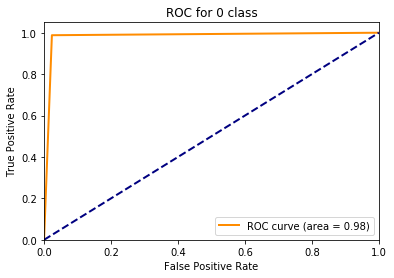

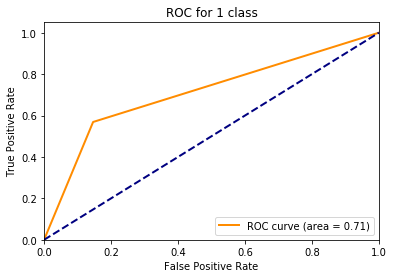

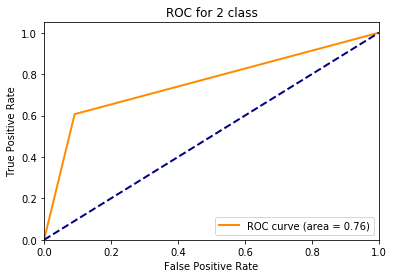

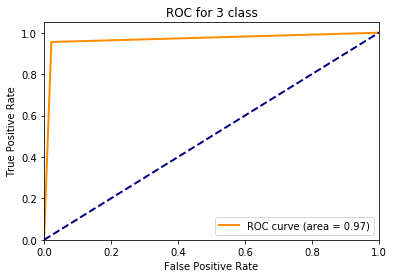

In [119]:
preds = best_model.predict(X_test)
print(f"f1 score = {f1_score(y_test, preds, average='micro')}")

for i in range(0, 4):
    plot_roc_auc_multiclass(y_test, preds, i)

#### 2.2. Зависимость объясненной дисперсии от числа главных компонент.
Воспользуемся методом главных компонент (PCA). 

Примените его к train-части данных.
Постройте график зависимости объясненной дисперсии (explained variance ratio) от количества главных компонент.

Text(0, 0.5, 'Explained Variance')

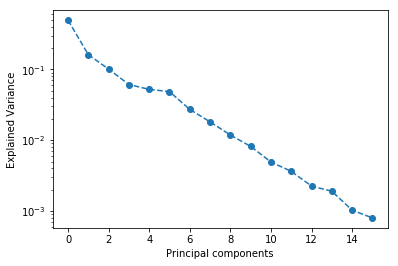

In [131]:
pca = PCA(n_components=16)
pca.fit(X_train)
plt.semilogy(pca.explained_variance_ratio_, '--o')
plt.xlabel('Principal components')
plt.ylabel('Explained Variance')

#### 2.3. Преобразование с помощью PCA.
Выберите определенное число компонент. Кратко опишите, чем обусловлен ваш выбор.

Используя эти главные компоненты, преобразуйте train и test выборки (используя методы `fit` и `transform`).

In [152]:
pca.explained_variance_ratio_

array([0.49718097, 0.1600401 , 0.09796046, 0.06229841, 0.05189628,
       0.04818295, 0.02987334, 0.01844471, 0.01130352, 0.00775411,
       0.00494791, 0.00321967])

In [5]:
# 90% дисперсии "обьясняют" первые 10 фич
pca = PCA(n_components=10)
X_train, X_test, y_train, y_test = my_train_test_split()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

/home/max/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/max/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/max/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### 2.4. Логистическая регрессия над преобразованными данными.
* Подберите оптимальные параметры логистической регресии с помощью кросс-валидации на преобразованном train-датасете.

* Постройте график ROC-кривой для полученных классификаторов, оцените точность классификации и f1-score. 

In [166]:
### YOUR CODE HERE
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(Cs=C, cv=5, random_state=0, penalty='l2').fit(X_train, y_train)

/home/max/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


f1 score = 0.7037037037037037


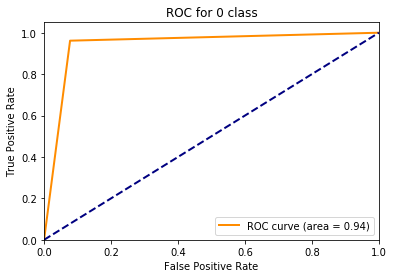

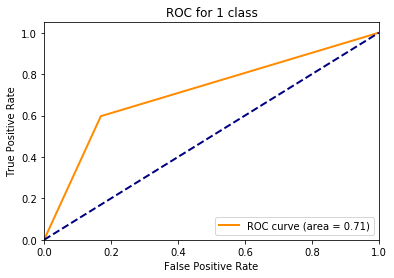

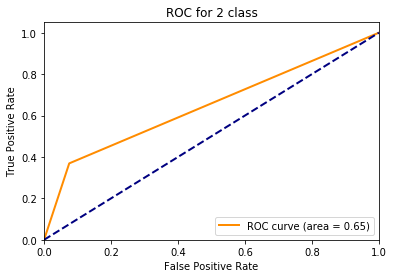

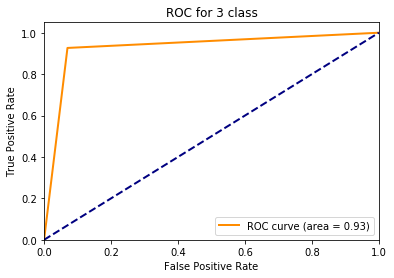

In [167]:
preds = clf.predict(X_test)
print(f"f1 score = {f1_score(y_test, preds, average='micro')}")

for i in range(0, 4):
    plot_roc_auc_multiclass(y_test, preds, i)

#### 2.5. Решающее дерево.
Рассмотрим поведение решающего дерева на исходных и преобразованных данных. Будем варьировать лишь один параметр - максимальную глубину дерева. 

* С помощью кросс-валидации подберите оптимальный параметр `max_depth` и оцените на исходных и преобразованных данных те же метрики, что и выше.

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
best_model = clf.fit(X_train, y_train)

/home/max/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
best_model.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

f1 score = 0.6565656565656566


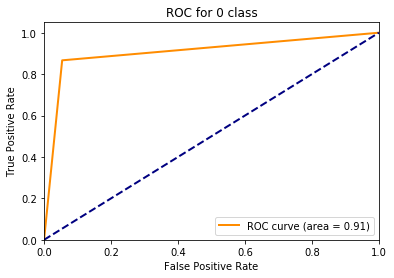

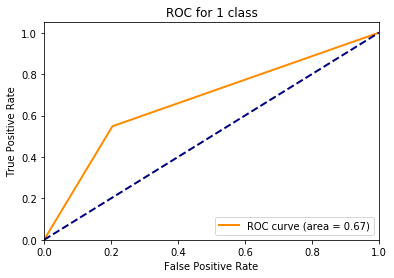

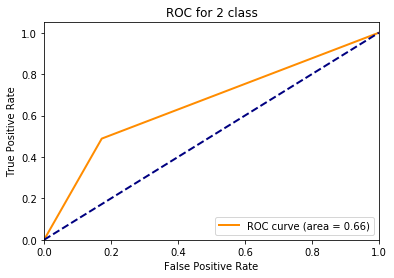

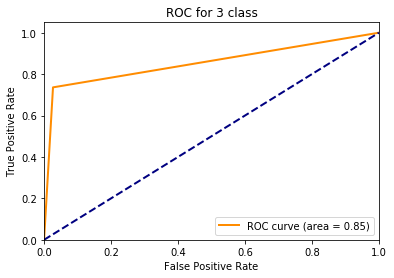

In [11]:
preds = best_model.best_estimator_.predict(X_test)
print(f"f1 score = {f1_score(y_test, preds, average='micro')}")

for i in range(0, 4):
    plot_roc_auc_multiclass(y_test, preds, i)

#### 2.6. Bagging.
Перейдем к ансамблям. 

Для построения ансамбля воспользуемся Bagging'ом с числом алгоритмов от 2 до 50. В качестве первого семейства базовых алгоримтов будем использовать линейные модели (т.е. логистическую регрессию), в качестве второго - решающие деревья. 

*Пояснение: Будем строить ансамбль только из моделей из одного семейства, т.е. логистическая регрессия не смешивается с решающими деревьями.*

Для этого можно сгенерировать с помощью метода bootstrap 50 подвыборок из `train` выборки (того же размера, что и исходная), обучить логистическую регрессию и решающее дерево с оптимальными параметрами из предыдущего пункта на каждой из подвыборок и затем усреднить предсказания k моделей.

*Hint: в sklearn может найтись подходящая функция, которая облегчит вам реализацию данного пункта.*

* Постройте график качества классификации и f1-score на `train` и `test` датасетах в зависимости от числа алгоритмов, вошедших в ансамбль.

* Проанализируйте график. Какое количество моделей стоит использовать? Как вы думаете, являются ли параметры решающего дерева, подобранные в предыдущем пункте оптимальными в данном случае?

In [22]:
from sklearn.ensemble import BaggingClassifier

In [23]:
logreg_best_params = {
                         'C': 21.544346900318832,
                         'class_weight': None,
                         'dual': False,
                         'fit_intercept': True,
                         'intercept_scaling': 1,
                         'max_iter': 10000,
                         'multi_class': 'multinomial',
                         'n_jobs': None,
                         'penalty': 'l2',
                         'random_state': None,
                         'solver': 'saga',
                         'tol': 0.0001,
                         'verbose': 0,
                         'warm_start': False
                    }

In [28]:
bagging_logreg = BaggingClassifier(LogisticRegression(**logreg_best_params), n_estimators=50,
                            max_samples=1.0, max_features=0.5)
bagging_logreg.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=21.544346900318832, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=1.0, n_estimators=50, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

f1 score = 0.6868686868686869


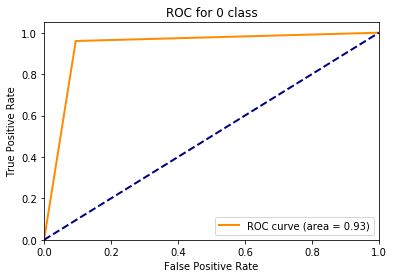

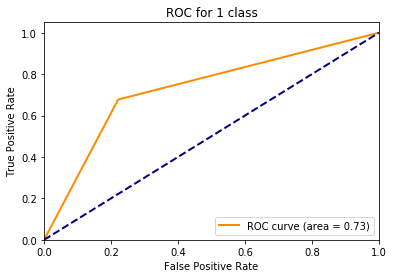

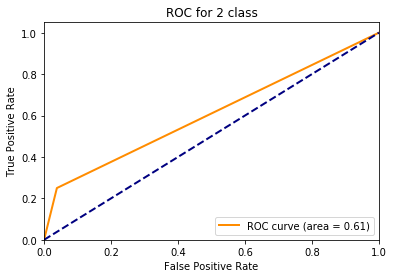

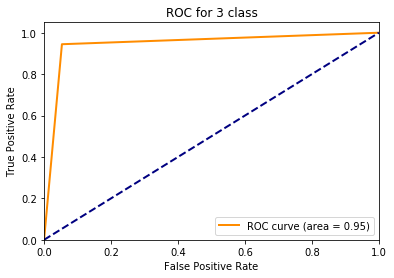

In [29]:
preds = bagging_logreg.predict(X_test)
print(f"f1 score = {f1_score(y_test, preds, average='micro')}")

for i in range(0, 4):
    plot_roc_auc_multiclass(y_test, preds, i)

In [49]:
tree_best_params = {'class_weight': None,
                     'criterion': 'gini',
                     'max_depth': 9,
                     'max_features': 'auto',
                     'max_leaf_nodes': None,
                     'min_impurity_decrease': 0.0,
                     'min_impurity_split': None,
                     'min_samples_leaf': 1,
                     'min_samples_split': 2,
                     'min_weight_fraction_leaf': 0.0,
                   }

In [50]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(**tree_best_params), n_estimators=30,
                            max_samples=1.0, max_features=0.5)
bagging_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=1.0, n_estimators=30, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

f1 score = 0.6430976430976431


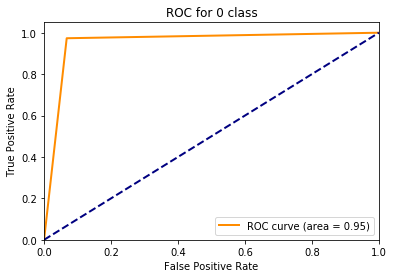

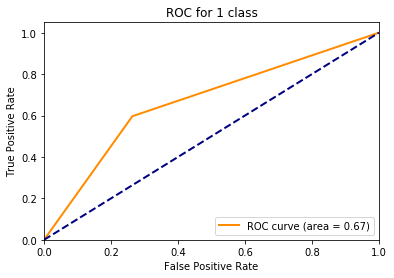

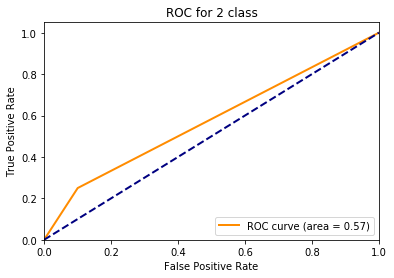

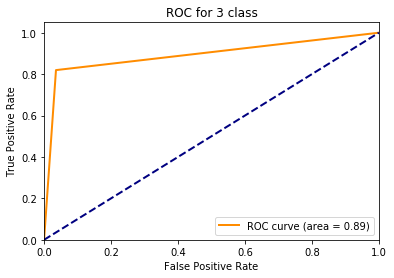

In [52]:
preds = bagging_tree.predict(X_test)
print(f"f1 score = {f1_score(y_test, preds, average='micro')}")

for i in range(0, 4):
    plot_roc_auc_multiclass(y_test, preds, i)

#### 2.7. Random Forest.
Теперь воспользуйтесь `sklearn`-реализацией алгоритма Random Forest. 

* Постройте аналогичные графики для него (изменяя число деревьев от 1 до 50). Остальные параметры можно оставить по умолчанию.

* Проанализируйте полученные результаты. Каким получилось оптимальное число деревьев. Как оно соотносится с оптимальным числом деревьев и линейных моделей в bagging'е из предыдущего пункта?

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
from sklearn.ensemble import RandomForestClassifier

tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150, 200, 300, 500, 1000]}
clf = GridSearchCV(RandomForestClassifier(), tree_para, cv=7)
best_model_random_forest = clf.fit(X_train, y_train)

f1 score = 0.6868686868686869


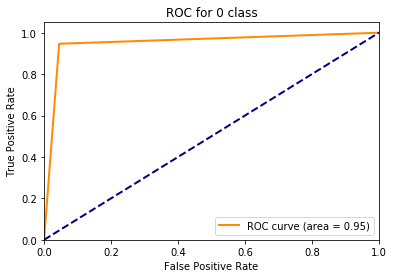

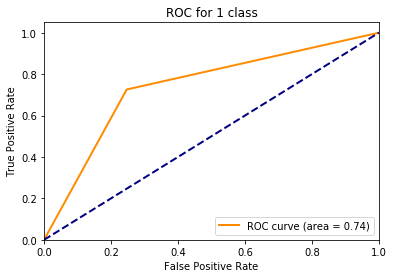

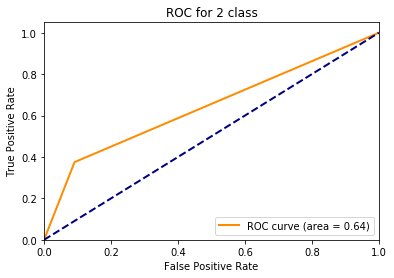

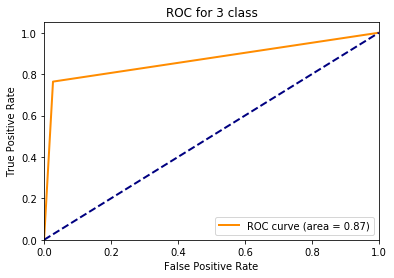

In [60]:
preds = best_model_random_forest.best_estimator_.predict(X_test)
print(f"f1 score = {f1_score(y_test, preds, average='micro')}")

for i in range(0, 4):
    plot_roc_auc_multiclass(y_test, preds, i)

#### 2.8. Кривая обучения.
* Поделите обучающую выборку на 10 примерно равных частей. Обучите логистическую регрессию (с оптимальными параметрами), решающее дерево (аналогично), бэггинг над логистическими регрессиями и решающими деревьями (с выбранными параметрами) и RandomForest (из предыдущего пункта) на одной, двух, трех и т.д. частях.

* Постройти график f1-score и accuracy на `train` и `test` датасетах в зависимости от размера обучающей выборки.

* Проанализируйте полученный график. Можно ли сделать из него какие-либо выводы? Если да - кратко опишите их.

In [71]:
y_train_batch

array([], shape=(0, 1), dtype=float64)

In [70]:
y_train[i:i+step]

array([3, 2, 2, 1, 2, 1, 0, 2, 2, 0, 0, 2, 2, 3, 3, 1, 2, 1, 1, 2, 1, 0,
       1, 3, 2, 2, 1, 2, 2, 2, 3, 1, 3, 1, 3, 0, 2, 1, 2, 2, 0, 2, 1, 0,
       0, 0, 1, 0, 0, 2, 3, 2, 2, 3])

In [81]:
from sklearn.metrics import accuracy_score

In [92]:
f1_scores = {'logreg': [],
             'tree': [],
             'random_forest': [],
             'logreg_bagging': [],
             'tree_bagging': []}

acc_scores = {'logreg': [],
             'tree': [],
             'random_forest': [],
             'logreg_bagging': [],
             'tree_bagging': []}

step = X_train.shape[0] // 10
X_train_batch, y_train_batch = np.ndarray(shape=(0, X_train.shape[1])), np.ndarray(shape=(0, 1))
for i in range(step, 10 * step, step):
    X_train_batch = np.vstack([X_train_batch, X_train[i:i+step, :]])
    y_train_batch = np.vstack([y_train_batch, y_train[i:i+step, np.newaxis]])
    
    rf = RandomForestClassifier(**best_model_random_forest.best_estimator_.get_params())
    b_tree = BaggingClassifier(DecisionTreeClassifier(**tree_best_params), n_estimators=30,
                               max_samples=1.0, max_features=0.5)
    tree = DecisionTreeClassifier(**tree_best_params)
    lr = LogisticRegression(**logreg_best_params)
    b_lr =  BaggingClassifier(LogisticRegression(**logreg_best_params), n_estimators=50,
                            max_samples=1.0, max_features=0.5)

    models = [rf, b_tree, lr, b_lr, tree]
    for index, model in enumerate(models):
        model.fit(X_train_batch, y_train_batch)
        preds = model.predict(X_test)
        score_f1 = f1_score(y_test, preds, average='micro')
        acc = accuracy_score(y_test, preds)
        
        label = None
        if index == 0:
            label = 'random_forest'
        elif index == 1:
            label = 'tree_bagging'
        elif index == 2:
            label = 'logreg'
        elif index == 3:
            label = 'logreg_bagging'
        elif index == 4:
            label = 'tree'
            
        f1_scores[label] += [score_f1]
        acc_scores[label] += [acc]

In [104]:
def plot_metrics(scores, title=''):
    plt.xlabel('dataset size')
    plt.title(title)
    for key, value in scores.items():
        plt.plot(value, label=key)
    plt.legend()

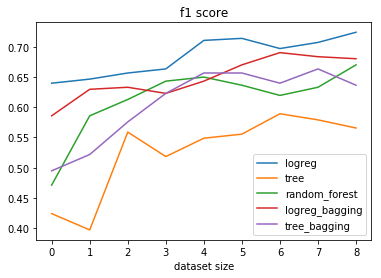

In [105]:
plot_metrics(f1_scores, 'f1 score')

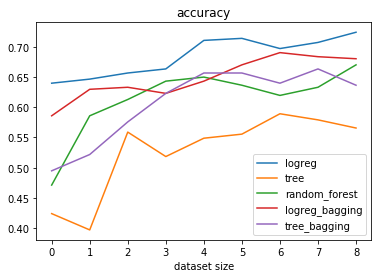

In [106]:
plot_metrics(acc_scores, 'accuracy')

Из графиков видно, что метрики accuracy и f1 score, а, значит, и качество классификатора, растут с ростом размера обучающей выборки

Вторая часть задания про SVM ждет вас в соседнем ноутбуке.